In [5]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

In [10]:
#This functions generate data corresponding to two outputs
f_output1 = lambda x: 4. * np.cos(x/5.) - .4*x - 35. + np.random.rand(x.size)[:,None] * 2.
f_output2 = lambda x: 6. * np.cos(x/5.) + .2*x + 35. + np.random.rand(x.size)[:,None] * 8.


#{X,Y} training set for each output
X1 = np.random.rand(100)[:,None]; X1=X1*75
X2 = np.random.rand(100)[:,None]; X2=X2*70 + 30
Y1 = f_output1(X1)
Y2 = f_output2(X2)
print(X1.shape, X2.shape, Y1.shape, Y2.shape)
#{X,Y} test set for each output
Xt1 = np.random.rand(100)[:,None]*100
Xt2 = np.random.rand(100)[:,None]*100
Yt1 = f_output1(Xt1)
Yt2 = f_output2(Xt2)
print(Xt1.shape, Xt2.shape, Yt1.shape, Yt2.shape)

(100, 1) (100, 1) (100, 1) (100, 1)
(100, 1) (100, 1) (100, 1) (100, 1)


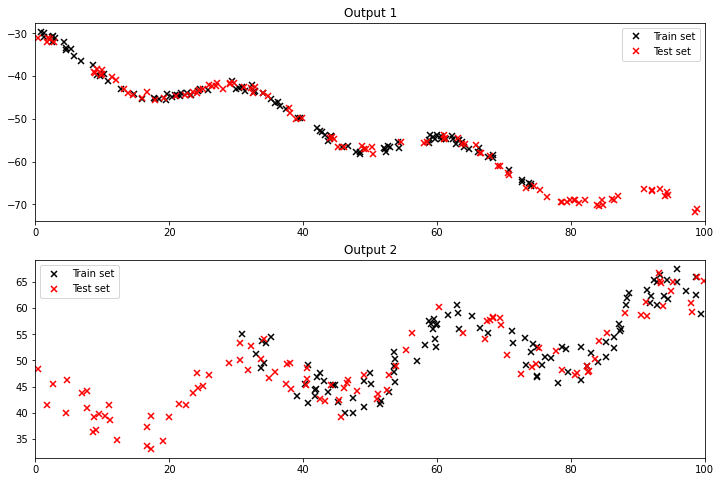

In [8]:
xlim = (0,100); ylim = (0,50)
fig, ax = plt.subplots(2, figsize=(12,8))

ax[0].set_xlim(xlim)
ax[0].set_title('Output 1')
ax[0].plot(X1[:,:1],Y1,'kx',mew=1.5,label='Train set')
ax[0].plot(Xt1[:,:1],Yt1,'rx',mew=1.5,label='Test set')
ax[0].legend()

ax[1].set_xlim(xlim)
ax[1].set_title('Output 2')
ax[1].plot(X2[:,:1],Y2,'kx',mew=1.5,label='Train set')
ax[1].plot(Xt2[:,:1],Yt2,'rx',mew=1.5,label='Test set')
ax[1].legend()
plt.show()

In [9]:
def plot_2outputs(m,xlim,ylim):   
    # Output 1
    fig, ax = plt.subplots(2, figsize=(12,8))
    ax[0].set_xlim(xlim)
    ax[0].set_title('Output 1')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,0)],which_data_rows=slice(0,100),ax=ax[0])
    ax[0].plot(Xt1[:,:1],Yt1,'rx',mew=1.5)
    ax[0].legend()
    # Output 2
    ax[1].set_xlim(xlim)
    ax[1].set_title('Output 2')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,1)],which_data_rows=slice(100,200),ax=ax[1])
    ax[1].plot(Xt2[:,:1],Yt2,'rx',mew=1.5)
    ax[1].legend()
    plt.show()

In [12]:
X12 = np.concatenate((X1, X2), axis=0)
idx = np.concatenate((np.zeros(len(X1)), np.zeros(len(X2))))[:, None]
X = np.concatenate((X12, idx), axis=1)
y = np.concatenate((Y1, Y2))
print(X12.shape, idx.shape, X.shape)

(200, 1) (200, 1) (200, 2)


### PyMC model

In [25]:
with pm.Model() as model:
    ls = pm.Gamma("ls", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=2, beta=0.5)
    cov = eta**2 + pm.gp.cov.ExpQuad(1, ls=ls, active_dims=[0])
    
    W = pm.Normal("W", mu=3, sigma=2, shape=(2,2), testval=np.random.randn(2,2))
    kappa = pm.Gamma('kappa', alpha=2, beta=0.5, shape=2)
    coreg = pm.gp.cov.Coregion(input_dim=2, active_dims=[1], kappa=kappa, W=W)
    cov_func = coreg * cov
    
    sigma = pm.HalfNormal("sigma", sigma=3)
    gp = pm.gp.Marginal(cov_func=cov_func)
    y_ = gp.marginal_likelihood("y", X, y, noise=sigma)
    

/tmp/ipykernel_11468/1704840781.py:6: FutureWarning: The `testval` argument is deprecated; use `initval`.
  W = pm.Normal("W", mu=3, sigma=2, shape=(2,2), testval=np.random.randn(2,2))


In [ ]:
%%time
with model:
    gp_trace = pm.sample(200, chains=1)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ls, eta, W, kappa, sigma]


In [ ]:
Xt12 = np.concatenate((Xt1, Xt2), axis=0)
idx = np.concatenate((np.zeros(len(Xt1)), np.zeros(len(Xt2))))[:, None]
X_new = np.concatenate((Xt12, idx), axis=1)
yt = np.concatenate((Yt1, Yt2))
print(Xt12.shape, idx.shape, X_new.shape, yt.shape)

In [ ]:
with model:
    preds = gp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42)

In [ ]:
from pymc.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

f_preds = gp_samples.posterior_predictive["preds"].sel(chain=0)
plot_gp_dist(ax, f_preds[:,:100], X_new[:100,0], palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
plot_gp_dist(ax, f_preds[:,100:], X_new[100:,0], palette="Blues", fill_alpha=0.5, samples_alpha=0.1)


### Reference

https://nbviewer.org/github/SheffieldML/notebook/blob/master/GPy/coregionalized_regression_tutorial.ipynb